# Week 7 - Temporal models 

## Part 3: Road traffic - Time-series imputation

In this part, we will specify a simple linear dynamical system (LDS) in STAN in order to do **imputation** on the freeway occupancy rates. Time-series imputation, and imputation of missing values in general, is a problem that arises very frequently when dealing with real data from real-world problems. 

There exist many imputation techniques in the literature, but here we will consider model-based approaches. Since we have a probabilistic model for our problem, all we need to do is to treat the missing observations as latent variables in the model and do inference on them - this is the Bayesian way! (and arguably the best way of properly doing imputation... :-) ) This is because the Bayesian framework provide us with a coherent way for handling missing observations.

The usual imports...

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

The data consists of time-series of freeway occupancy rates (rows), with length $T=1008$, at 10 different consecutive sensors/detectors (columns). Although we will focus only on the data from a single detector as an example...

Load data:

In [2]:
# load csv
df = pd.read_csv("PeMS_sample.csv")
df.head()

,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
0,0.0154,0.0054,0.0164,0.0079,0.0059,0.0138,0.0111,0.0156,0.0154,0.0080
1,0.0085,0.0051,0.0127,0.0062,0.0051,0.0125,0.0099,0.0175,0.0134,0.0067
2,0.0099,0.0056,0.0172,0.0068,0.0053,0.0116,0.0105,0.0157,0.0112,0.0065
3,0.0108,0.0045,0.0126,0.0072,0.0058,0.0131,0.0073,0.0146,0.0128,0.0040
4,0.0100,0.0037,0.0185,0.0048,0.0063,0.0099,0.0061,0.0157,0.0123,0.0064


Some basic data statistics:

In [3]:
print("Dataset size:", len(df))
print("General statistics:")
df.describe()

Dataset size: 1008
General statistics:


,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.00000,1008.000000
mean,0.049489,0.044541,0.066207,0.051599,0.026812,0.047976,0.037051,0.055881,0.05583,0.049262
std,0.030016,0.047490,0.047321,0.040934,0.019402,0.052455,0.036248,0.049275,0.04192,0.042152
min,0.005300,0.000000,0.000000,0.000000,0.001900,0.002200,0.002900,0.002500,0.00150,0.001500
25%,0.027150,0.014900,0.029525,0.018000,0.013100,0.014775,0.012075,0.017950,0.01820,0.027075
50%,0.055300,0.038600,0.070500,0.046400,0.021700,0.038750,0.029000,0.051500,0.05665,0.046700
75%,0.064400,0.051900,0.088025,0.070800,0.030925,0.054125,0.045400,0.069825,0.07670,0.058925
max,0.317600,0.355000,0.393600,0.232700,0.094900,0.316900,0.197200,0.307400,0.22060,0.408100


Visualize data (part of it):

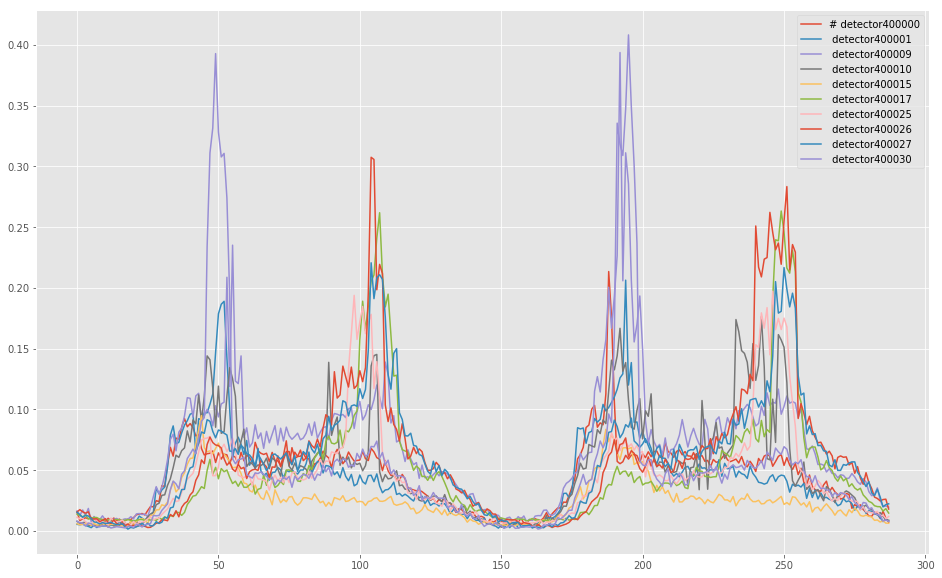

In [16]:
plt.plot(df[:(2*24*6)]) # first 2 days (2*24*6 10-minute intervals) of each of the 10 detectors
plt.legend(df.columns);

Lets now generate some articial missing data at random. To make things challenging, will consider a difficult setting were **80% of the observations are missing**. 

Notice that we save the real observations for the 80% missings, in order to evaluate the accuracy of our imputations later on.

In [5]:
# convert data to a matrix
y = df.values
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=144, D=10


In [6]:
missing_perc = 0.8 # missing percentage

perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7] #Using data in column 7 (ID=detector400026)
y_obs1 = y[ix_obs1,7]  

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print("N_obs:", N_obs)
print("N_mis:", N_mis)

N_obs: 29
N_mis: 115


Ok, time to go to STAN!

Implementing imputation in STAN requires you to notice that you must tell STAN which observations are missings and therefore must go in the "parameters" block, in order for STAN to compute their posterior distribution (inference). In a way, this is similar to what we did in the forecasting notebook, where we told STAN that there exist these extra "T_forecast" variables, z[T:T_forecast], which follow the same dynamics as the previous z's, and that STAN should do inference on them (remember, we put them in the "parameters" block as well).

In the case of time-series imputation, we will do the following:
-  Besides the observed values (y_obs), we will pass STAN two arrays: one with the indexes of the time-series that are observed (ix_obs), and another with missing indexes (ix_mis). You may also need to tell STAN the number of missings and the number of observed variables...
- In the "parameters" block, we need to specify which variables we want STAN to inference on. Therefore, this block must include, among others, an array "y_mis" with the missing observations from the time-series.
- In order for the "model" block to be as "clean" (or readable) as possible, we will use the "transformed parameters" block to define an array "y" of size T = N_obs + N_mis, which contains both the missing and the observed variables. In this way, in the "model" block we can specify the likelihood simply as "y ~ normal(z, sigma)".

Notice that this in not the only way of doing imputation in STAN! However, it is a very "clean" way of doing it, since the "model" block contains just the specification of the model itself, instead of details about missing observations.

For the purpose of demonstration (and for faster inference!), we will use a simple autoregressive model of order 1, AR(1), of the form:

\begin{align}
z_t &\sim \mathcal{N}(\beta z_{t-1}, \tau^2)\\
y_t &\sim \mathcal{N}(z_t, \sigma^2)
\end{align}

Now, it is your turn! Can you write the STAN program? We know it is an intimidating task at first, so do not hesitate to ask questions and clarifications! :-)

In [7]:
# define Stan model
model_definition = """
// TODO
"""

In [8]:
# prepare data for Stan model
data = {'N_obs': N_obs, 'N_mis': N_mis, 'ix_obs': ix_obs1+1, 'ix_mis': ix_mis1+1, 'y_obs': y_obs1}

Compile STAN program:

In [9]:
%%time
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8beae3f50473ee4313c5f532babc1232 NOW.
/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/gy/zs468fmx43v7gcy1m87k228c0000gn/T/tmphlr_ia3_/stanfit4anon_model_8beae3f50473ee4313c5f532babc1232_2998301441773460439.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


CPU times: user 1.82 s, sys: 126 ms, total: 1.95 s
Wall time: 47.3 s


Run inference using MCMC:

In [10]:
%%time
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

Inference for Stan model: anon_model_8beae3f50473ee4313c5f532babc1232.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]      0.98  1.1e-3   0.02   0.94   0.97   0.98   0.99   1.01    248   1.01
tau          0.01  3.1e-4 2.9e-3   0.01   0.01   0.01   0.02   0.02     87   1.02
sigma        0.01  9.3e-4 4.4e-3 3.5e-3 7.2e-3 9.9e-3   0.01   0.02     22   1.12
z[1]         0.02  9.4e-4   0.02  -0.02 5.4e-3   0.02   0.03   0.06    400    1.0
z[2]         0.02  3.4e-4   0.01-2.4e-3   0.01   0.02   0.02   0.04    927   1.01
z[3]         0.02  2.4e-3   0.02  -0.02 6.3e-3   0.02   0.03   0.06     65   1.04
z[4]         0.02  2.7e-3   0.02  -0.02 3.0e-3   0.02   0.04   0.07     78   1.03
z[5]         0.02  1.9e-3   0.03  -0.03 1.0e-3   0.02   0.04   0.07    180   1.02
z[6]         0.02  2.2e-3   0.03  -0.03-1.6e-3   0.02   0.04   0.07    152  

Extract samples and plot posteriors over some of the latent variables (parameters): tau and sigma

In [11]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

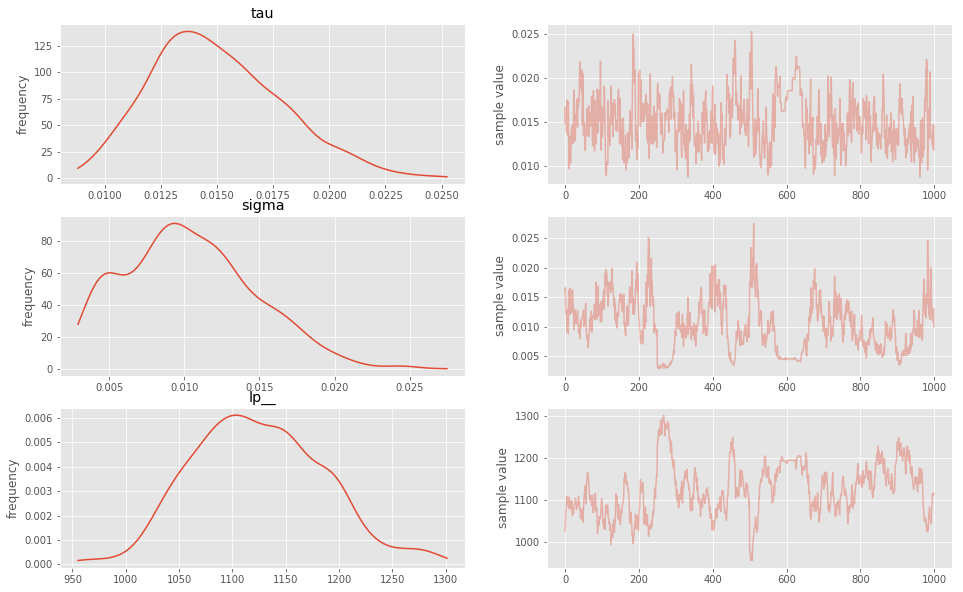

In [17]:
fit.plot(["tau","sigma","lp__"])
plt.show()

Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [18]:
# get mean and standard devitions for predictions
y_hat = samples["y_mis"].mean(axis=0)
y_std = samples["y_mis"].std(axis=0)

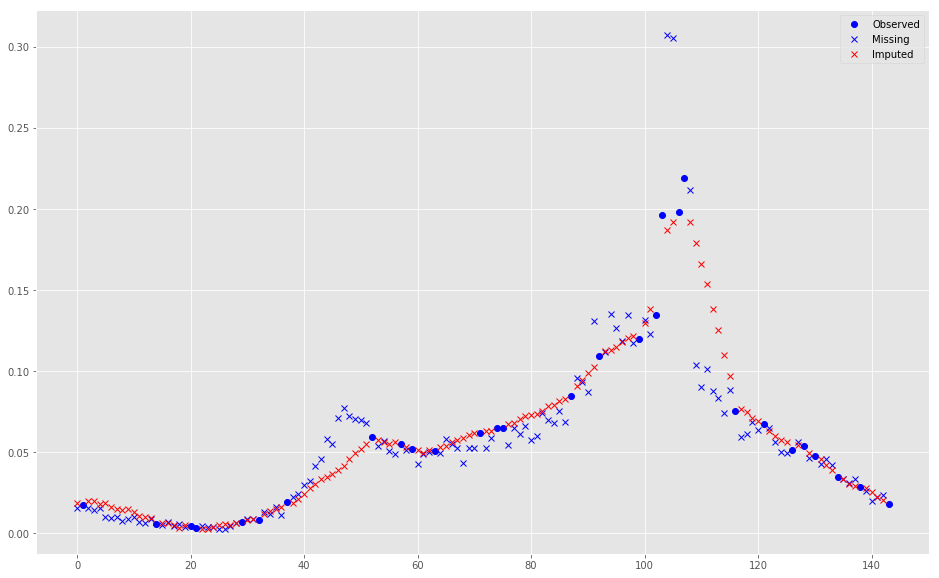

In [22]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
plt.legend(["Observed", "Missing", "Imputed"]);
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")

Compute error statistics of the model's imputations:

In [23]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [24]:
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.895
MAE: 0.01138
RMSE: 0.02245
R2: 0.801


Not too bad... But our model was quite naive. We can definitely do better with a more appropriate model, i.e. that exploits our prior knowledge about this particular problem. That is what we shall do in the next notebook! :-)